In [1]:
import os
import time

import numpy as np
import pandas 
import geopandas

from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import re
from pprint import pprint
from matplotlib.path import Path
from matplotlib.patches import BoxStyle



thisyear = 2018
#this_state = 'MO'

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
output_dir = data_dir

acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'
#separated_roads_dir = output_dir = '/home/idies/workspace/Temporary/raddick/jordanraddick.com_temp/roads/{0:}/'.format(this_state.lower())


water_area_tol = 1 * 1000 * 1000
overlap_area_tract_tol = 22000
overlap_area_bg_tol = 4000
#smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
#smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)
equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163

scale = 1
#map_buffer = 0.25 # extra room on each edge of the maps, in degres

#plt.rc('axes', prop_cycle=default_cycler)

district_color_cycle = ['red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_contrast_color_cycle = ['green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']

debug = 1
g = 0




def makebox(manual_xlim, manual_ylim):

    points = []
    points.append(Point(manual_xlim[0],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[0]))
    points.append(Point(manual_xlim[0],manual_ylim[0]))
    
    coords = [(p.x, p.y) for p in points]    
    metrobox = Polygon(coords)
    
    return metrobox 
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'orange', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'orange' }
}
old_map_buffer_ratio = -1
print('ok')



ok


# Get congressional district shapefiles

WITH data on metro and city areas as a percentage of total district area.

This assumes that you have already run <code>districts-cities.ipynb</code>.

In [2]:
s = time.time()
print('reading congressional districts with urban/rural area data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())


reading congressional districts with urban/rural area data...
Fixing at-large districts by setting district number to 1...
Read 435 districts in 2.2 seconds.


# Load block groups (nationwide)

In [3]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers and coords to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')
bg_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(bg_gdf['INTPTLAT'], errors='coerce')
bg_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(bg_gdf['INTPTLON'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

#bg_gdf.sample(1).T


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers and coords to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 162.6 seconds!


## Look up state and county names from numbers

In [4]:
s = time.time()

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df = state_codes_df.rename(columns={'STATE': 'STATEFP'})
bg_gdf = bg_gdf.reset_index().merge(state_codes_df, how='left', on='STATEFP').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATEFP', 'County Code (FIPS)': 'COUNTYFP', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
bg_gdf = bg_gdf.reset_index().merge(county_names_df[['STATEFP', 'COUNTYFP', 'COUNTY_NAME']], how='left', on=['STATEFP', 'COUNTYFP']).set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Added state and county names in {0:,.1f} seconds!'.format(e-s))


looking up state names from numbers...
looking up county names from numbers...
Added state and county names in 14.9 seconds!


## Get population data, and join onto shapefiles

In [5]:
s = time.time()
print('reading ACS5 census data for {0:.0f}...'.format(thisyear))
acs5_estimates_df = pandas.read_csv(acs5_dir+'estimates_acs{0:}_tract_bg_gerrymandering.csv'.format(thisyear), index_col='GEOID')

print('joining population data onto block group shapefiles...')
bg_gdf = bg_gdf.join(acs5_estimates_df[['B01001_001', 'Geography Name']], how='left')
bg_gdf = bg_gdf.rename(columns={'B01001_001': 'total_population'})

e = time.time()
g = g + (e-s)
print('\nadded ACS5 census data to {0:,.0f} block groups in {1:,.0f} seconds!'.format(len(bg_gdf), e-s))


reading ACS5 census data for 2018...
joining population data onto block group shapefiles...

added ACS5 census data to 217,739 block groups in 4 seconds!


# Geo-match congressional districts

If a tract overlaps with only one district, match that tract to its district.
If it overlaps multiple districts, divide into block groups and match each block group to its matching districts.

# READ FROM FILE

## Get what has been matched so far

In [6]:
# s = time.time()
# print('reading districts that have been matched so far...')
# assembler_df = pandas.read_csv(output_dir+'raw_district_files/ak_to_pa_sortof.csv', encoding='utf-8', index_col='GEOID')
# assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
# assembler_gdf.crs = bg_gdf.crs


# # cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
# # bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

# print('backing up...')
# # cd_gdf_bk = cd_gdf
# # bg_gdf_bk = bg_gdf
# assembler_gdf_bk = assembler_gdf

# e = time.time()
# g = g + (e-s)
# print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))

# assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)


### READ AFRESH

In [7]:
s = time.time()
print('reading districts that have been matched so far...')
assembler_df = pandas.read_csv(data_dir+'block_group_with_district_1_14.csv', encoding='utf-8', index_col='GEOID')
assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
assembler_gdf.crs = bg_gdf.crs


# cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
# bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

print('backing up...')
cd_gdf_bk = cd_gdf
bg_gdf_bk = bg_gdf
assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)
print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))




reading districts that have been matched so far...
backing up...
Kept 217,739 block groups in 1.7 seconds!


## States with 16-18 districts

These are harder, because first we have to know which block groups overlap multiple districts.

Create a function to mark those.

### Create function to mark block groups with the districts they overlap

In [8]:
def mark_block_groups_with_districts_bitmask_values(block_group_info_gdf, congressional_district_info_gdf, debug=0):    
    working_with_state = block_group_info_gdf['STATE_NAME'].head(1).values[0]
    
    marked_s = pandas.Series()
    
    equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
    cnt = 0
    if (debug > 0):    
        print('\tAssigning bitmask values to block groups in {0:}...'.format(working_with_state))
    
    for ix, thisrow in block_group_info_gdf.iterrows():    
        bitmasker = 0
        if (debug > 1):
            print(ix)
            print('\t\tMatching {0:}, {1:} census tract {2:}, block group {3:}...'.format(thisrow['STATE_NAME'], thisrow['COUNTY_NAME'], thisrow['TRACTCE'], thisrow['BLKGRPCE']))
            print('\n')
        if ((np.mod(cnt,100) == 0) | (cnt == len(block_group_info_gdf) - 1)):
            if (debug > 1):
                print('\t\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
            else:
                print('\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
                
        for jx, thatrow in congressional_district_info_gdf.iterrows():
            if (thisrow.geometry.intersects(thatrow.geometry)):
                this_district_overlap_area = block_group_info_gdf[block_group_info_gdf.index == ix].to_crs(equal_area_crs).geometry.values[0].intersection(congressional_district_info_gdf[congressional_district_info_gdf.index == jx].to_crs(equal_area_crs).geometry.values[0]).area
                if (this_district_overlap_area >= overlap_area_bg_tol):
                    bitmasker = bitmasker + 2**(thatrow['CD116FP']-1)
                    if (debug > 1):
                        print('\t\t\t\tIntersects District {0:.0f} with overlap area {1:,.1f} km^2...'.format(thatrow['CD116FP'], this_district_overlap_area/1000000))               
        marked_s.loc[ix] = bitmasker
        cnt = cnt + 1
        
    return marked_s
print('defined district-marking function!')
#assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)


defined district-marking function!


## Find block group / district overlaps, assign districts to non-overlapping block groups

Uses function defined above

In [9]:
s = time.time()

print('getting from backup...')
bg_gdf = bg_gdf_bk
assembler_gdf = assembler_gdf_bk



for this_state in ['OH', 'IL', 'PA']:
#     try:
#         print('reading previously-parsed {0:} census tracts from file...'.format(this_state))
#         assembler_from_file_gdf = geopandas.read_file(output_dir+'raw_district_files/{0:}_raw.shp'.format(this_state.lower()))
#         assembler_gdf = pandas.concat((assembler_gdf, assembler_from_file_gdf), axis=0, sort=True)
#     except:
#    print('File not found, reading from nationwide data...')
    state_full_name = bg_gdf[bg_gdf['STUSAB'] == this_state]['STATE_NAME'].values[0]
    print('\n')
    print('Processing {0:}...'.format(state_full_name))
    assembler_i_gdf = bg_gdf[bg_gdf['STUSAB'] == this_state]

    district_bitmask_values_s = mark_block_groups_with_districts_bitmask_values(
        bg_gdf[bg_gdf['STUSAB'] == this_state][['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population', 'geometry']], 
        cd_gdf[cd_gdf['STUSAB'] == this_state][['STUSAB', 'CD116FP', 'geometry']], 
        debug
    )
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask_values = district_bitmask_values_s)


    if (debug > 0):
        print('\tconverting bitmask values to human-readable bitmasks...')        
    nDistrictsForBitmaskeration = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116FP'].max()
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask = 
                                             assembler_i_gdf['congressional_districts_bitmask_values'].apply(lambda x: 'x'+np.binary_repr(int(x)).zfill(nDistrictsForBitmaskeration)[::-1])
                                            )

    if (debug > 0):
        print('\tcounting number of districts each block group overlaps...')        

    assembler_i_gdf = assembler_i_gdf.assign(nDistricts = 
                                             assembler_i_gdf['congressional_districts_bitmask'].apply(lambda x: x[1:].count("1"))
                                            )
    if (debug > 0):
        print('\tassigning congressional district to each block group with only one overlap...')

    assembler_i_gdf = assembler_i_gdf.assign(block_based_district = np.nan)
    assembler_i_gdf.loc[
        assembler_i_gdf['nDistricts'] == 1, 
        'block_based_district'] = assembler_i_gdf[
                        assembler_i_gdf['nDistricts'] == 1
                    ]['congressional_districts_bitmask'].apply(lambda x: x.find("1"))

    print('\t...-1 otherwise...')
    assembler_i_gdf.loc[assembler_i_gdf['nDistricts'] > 1, 'block_based_district'] = -1

    #assembler_i_gdf.to_file(output_dir+'raw_district_files/nj_raw.shp')

    if (debug > 0):
        print('\tjoining {0:} to the rest of the assembler dataframe...'.format(state_full_name))
    assembler_gdf = pandas.concat((assembler_gdf, assembler_i_gdf), axis=0, sort=True)
    if (debug > 0):
        print("\n")
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))

print('backing up...')
assembler_gdf_justparsed = assembler_gdf

e = time.time()
g = g + (e-s)

#print('Read {0:,.0f} rows in {1:,.0f} seconds!'.format(e-s, ))
print('Got {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

# print(assembler_gdf.groupby('STUSAB').size())
# print(assembler_gdf.groupby(['STUSAB', 'nDistricts']).size())
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# assembler_gdf.sample(2).T
#assembler_gdf[assembler_gdf['STUSAB'] == this_state].groupby('congressional_districts_bitmask').size()
assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)


getting from backup...


Processing Ohio...
	Assigning bitmask values to block groups in Ohio...
		processing row 1 of 9,238...
		processing row 101 of 9,238...
		processing row 201 of 9,238...
		processing row 301 of 9,238...
		processing row 401 of 9,238...
		processing row 501 of 9,238...
		processing row 601 of 9,238...
		processing row 701 of 9,238...
		processing row 801 of 9,238...
		processing row 901 of 9,238...
		processing row 1,001 of 9,238...
		processing row 1,101 of 9,238...
		processing row 1,201 of 9,238...
		processing row 1,301 of 9,238...
		processing row 1,401 of 9,238...
		processing row 1,501 of 9,238...
		processing row 1,601 of 9,238...
		processing row 1,701 of 9,238...
		processing row 1,801 of 9,238...
		processing row 1,901 of 9,238...
		processing row 2,001 of 9,238...
		processing row 2,101 of 9,238...
		processing row 2,201 of 9,238...
		processing row 2,301 of 9,238...
		processing row 2,401 of 9,238...
		processing row 2,501 of 9,238...
		processing ro

		processing row 2,101 of 9,740...
		processing row 2,201 of 9,740...
		processing row 2,301 of 9,740...
		processing row 2,401 of 9,740...
		processing row 2,501 of 9,740...
		processing row 2,601 of 9,740...
		processing row 2,701 of 9,740...
		processing row 2,801 of 9,740...
		processing row 2,901 of 9,740...
		processing row 3,001 of 9,740...
		processing row 3,101 of 9,740...
		processing row 3,201 of 9,740...
		processing row 3,301 of 9,740...
		processing row 3,401 of 9,740...
		processing row 3,501 of 9,740...
		processing row 3,601 of 9,740...
		processing row 3,701 of 9,740...
		processing row 3,801 of 9,740...
		processing row 3,901 of 9,740...
		processing row 4,001 of 9,740...
		processing row 4,101 of 9,740...
		processing row 4,201 of 9,740...
		processing row 4,301 of 9,740...
		processing row 4,401 of 9,740...
		processing row 4,501 of 9,740...
		processing row 4,601 of 9,740...
		processing row 4,701 of 9,740...
		processing row 4,801 of 9,740...
		processing row 4,9

STUSAB
IL    18.0
PA    18.0
OH    16.0
GA    14.0
MI    14.0
NC    13.0
NJ    12.0
VA    11.0
WA    10.0
AZ     9.0
TN     9.0
IN     9.0
MA     9.0
MN     8.0
MD     8.0
WI     8.0
MO     8.0
AL     7.0
SC     7.0
CO     7.0
KY     6.0
LA     6.0
CT     5.0
OR     5.0
OK     5.0
IA     4.0
KS     4.0
MS     4.0
NV     4.0
AR     4.0
UT     4.0
WV     3.0
NM     3.0
NE     3.0
ME     2.0
NH     2.0
RI     2.0
ID     2.0
HI     2.0
WY     1.0
DE     1.0
MT     1.0
ND     1.0
SD     1.0
VT     1.0
AK     1.0
Name: block_based_district, dtype: float64

In [10]:
# s = time.time()
# pandas.DataFrame(assembler_gdf[[x for x in assembler_gdf.columns if x != 'geometry']]
#                 ).to_csv(output_dir+'raw_district_files/ak_to_pa_sortof.csv', encoding='utf-8')
# e = time.time()
# g = g + (e-s)

# print('Wrote out {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))


In [11]:
s = time.time()
print('Assigning districts based on examination to block groups that overlap multiple districts...')


print('assigning districts...')

### OHIO
assembler_gdf.loc[['15000US390610215093', '15000US390610215094', '15000US390610215725', '15000US390610216043', '15000US390610215095', '15000US390610215096', '15000US390610216033', '15000US390610216044'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US390610218022', '15000US390610219001', '15000US390610216041', '15000US390610216031'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US390610081001', '15000US390610215044', '15000US390610080002', '15000US390610065001', '15000US390610111001', '15000US390610111002', '15000US390610037001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US390610215043', '15000US390610225002', '15000US390610060002', '15000US390610221027', '15000US390610040001'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US390610011001', '15000US390610019001', '15000US390610039002', '15000US390610040002', '15000US390610267001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US390610019002', '15000US390610041001', '15000US390610041002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US390610244002', '15000US390610244003', '15000US390610244004', '15000US390610244007', '15000US390610239012', '15000US390610239024', '15000US390610223024', '15000US390610273001', '15000US390610243031', '15000US390610243032', '15000US390610243214', '15000US390610243222'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US390610235211', '15000US390610240011', '15000US390610240021', '15000US390610243212', '15000US390610243035', '15000US390610243213'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US391450023002', '15000US391450024001', '15000US391450024003', '15000US391450024004', '15000US391450025002', '15000US391450025004', '15000US391450030002', '15000US391450030003', '15000US391450031001', '15000US391450031003'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US391450029004', '15000US391450025003', '15000US391450025001', '15000US391450030001', '15000US391450024002'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US391419557003', '15000US391419557004', '15000US391419567001', '15000US391419557003'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US391419566002', '15000US391419557002', '15000US391419558004'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US391419567003','15000US391419556021', '15000US391419560002', '15000US391419563001', '15000US391419563002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US391419558002', '15000US391419567002'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US390490073962', '15000US390490078202', '15000US390490069905', '15000US390490074922', '15000US390490073933', '15000US390490074252', '15000US390490073931', '15000US390490072103'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US390490073943', '15000US390490078122', '15000US390490012005', '15000US390490005003', '15000US390490004202', '15000US390490004203', '15000US390490013003', '15000US390490004102', '15000US390490006004', '15000US390490012002', '15000US390490067221', '15000US390490069212', '15000US390490069214', '15000US390490074244', '15000US390490074921', '15000US390490073934', '15000US390490073932', '15000US390490072102', '15000US390490072104'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US390490069444', '15000US390490069904', '15000US390490071141', '15000US390490071944', '15000US390490071981'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US390490072072', '15000US390490100001', '15000US390490071942', '15000US390490071943', '15000US390490070101', '15000US390490070102'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US390490030001', '15000US390490030002'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US390490084001', '15000US390490084002', '15000US390490084003', '15000US390490043001', '15000US390490082411', '15000US390490043002'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US390490018202', '15000US390490018203', '15000US390490019012', '15000US390490019021'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US390490088222', '15000US390490095904', '15000US390490095901', '15000US390490088131', '15000US390490094952', '15000US390490088131', '15000US390490095203', '15000US390490088251', '15000US390490088253'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US390490083802', '15000US390490097402', '15000US390490097403', '15000US390490103001', '15000US390490095903', '15000US390490094951', '15000US390490083803', '15000US390490095202', '15000US390490095201', '15000US390490088211', '15000US390490088221', '15000US390490083801', '15000US390490088252'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US390490081613', '15000US390490083503', '15000US390490096001', '15000US390490081611', '15000US390490081421', '15000US390490079411', '15000US390490081421', '15000US390490079533', '15000US390490081323', '15000US390490081423', '15000US390490094401', '15000US390490094403', '15000US390490094503', '15000US390490102004', '15000US390490011221'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US390490081612', '15000US390490098004', '15000US390490097521', '15000US390490079532', '15000US390490081411', '15000US390490081622', '15000US390490094971', '15000US390490065004'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US390490040001', '15000US390490040002', '15000US390490058103', '15000US390490061004', '15000US390490057001'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US390490052002', '15000US390490057003', '15000US390490052001', '15000US390490058101', '15000US390490057002', '15000US390490051001', '15000US390490083403'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US390490096001', '15000US390490083702', '15000US390490083503', '15000US390490097113'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US390490083301', '15000US390490083302', '15000US390490083401', '15000US390490083402', '15000US390490083703', '15000US390490097111', '15000US390490097201'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US391079675001', '15000US391079676002', '15000US391079676003'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US390779159001', '15000US390779159002', '15000US390779154002', '15000US390779154003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US390779159003', '15000US390779165001', '15000US390779165002', '15000US390930941001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US390930951001', '15000US390930951003', '15000US390930712022', '15000US390930713001', '15000US390930771002'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US390930912001', '15000US390930911002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US391079678001'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US391079679001'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US390930502001', '15000US390930702001', '15000US390930238001', '15000US390930240001'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US390430403004', '15000US390430404005', '15000US390930921001', '15000US390930972001', '15000US390930972002', '15000US390930503002', '15000US390930241001', '15000US390930241002', '15000US390930237003', '15000US390930239001', '15000US390930239002'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US391010101001', '15000US391010101003', '15000US391010103005'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US391079677001', '15000US391079680001', '15000US391079680002'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US390950058011', '15000US390950062001', '15000US390950072022', '15000US390950072042', '15000US390950045012', '15000US390950073011', '15000US390950072021'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US391230508002', '15000US390950045041', '15000US390950085004', '15000US390950086003', '15000US390950086004', '15000US390950072031', '15000US390950084003', '15000US390950084004', '15000US390950065002', '15000US390950064002', '15000US390950072051', '15000US390950073012'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US391570216001', '15000US391570217001', '15000US391570218001', '15000US391570215005', '15000US391570215004'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US391570212001', '15000US391570212002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US391199111002', '15000US391199128001', '15000US391199128001', '15000US391199128002', '15000US391199111003', '15000US391199119002', '15000US391199127001', '15000US391199127003', '15000US391199127004'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US391199113002', '15000US391199115001', '15000US391199116001', '15000US391199119001', '15000US391199119003', '15000US391199113001', '15000US391199112004'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US390998129001', '15000US390998129003'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US390099736001', '15000US390099736002'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US390099737002'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US391390023004', '15000US391390027004', '15000US391390027005', '15000US391390029001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US391390009002', '15000US391390018002', '15000US391390010003', '15000US391390020005', '15000US391390020002', '15000US391390020001', '15000US391390015002', '15000US391390023001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US391390010001', '15000US391390008001', '15000US391390009001', '15000US391390009003', '15000US391390015003', '15000US391390017001', '15000US391390016001'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US391517106001', '15000US391517106002', '15000US391517106003', '15000US391517128002'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US391034083012', '15000US391034082012', '15000US391034161001', '15000US391034158001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US391034154001', '15000US391034160004', '15000US391034161003'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US391034081004', '15000US391034081005', '15000US391034083024', '15000US391034082011', '15000US391034083022', '15000US391034083023'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US391034082022', '15000US391034082023', '15000US391034083011', '15000US391034161002'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US391517111112', '15000US391517111121'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US391517121121', '15000US391517121022', '15000US391517118001', '15000US391517117006', '15000US391517122011', '15000US391517122012'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US391517120001', '15000US391517121111', '15000US391517118004'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US391517132021', '15000US391517135012', '15000US391517114121', '15000US391517114122', '15000US391517135011', '15000US391517023001', '15000US391517134021', '15000US391517133002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US391517133001', '15000US391517114023', '15000US391517114124', '15000US391517134013', '15000US391517133003', '15000US391517025001', '15000US391517025002', '15000US391517134023'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US390351056022', '15000US390351057001', '15000US390351057002', '15000US390351051002', '15000US390351014001', '15000US390351016031', '15000US390351024023', '15000US390351027006', '15000US390351051001'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US390359900000', '15000US390351070001', '15000US390351015011', '15000US390351016032', '15000US390351018002', '15000US390351027003'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US390351053002', '15000US390351053003', '15000US390351054004', '15000US390351055002'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US390351049004'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US390351811004', '15000US390351607001', '15000US390351811003'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US390351811003', '15000US390351812031', '15000US390351812033', '15000US390351771013', '15000US390351775032'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US390351774051', '15000US390351774053', '15000US390351774055', '15000US390351776081', '15000US390351342031', '15000US390351342051', '15000US390351342062'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US390351774042', '15000US390351342052', '15000US390351342063'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US390479259002', '15000US390479260001', '15000US390479262001'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US390479264001', '15000US390479260002', '15000US390479263001'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US391535071023', '15000US391535061001'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US391535038001'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US391535323021', '15000US391535323022'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US391535323023'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US391535071011', '15000US391535071022', '15000US391535061006', '15000US391535061005', '15000US391535064003'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US391535072032', '15000US391535072034', '15000US391535071012', '15000US391535072012', '15000US391535073002', '15000US391535071021', '15000US391535064005', '15000US391535318021', '15000US391535038002', '15000US391535057004'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US391535056002', '15000US391535044001', '15000US391535044002', '15000US391535052001', '15000US391535083993', '15000US391535011001', '15000US391535074001', '15000US391535022002', '15000US391535075003'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US391535056001', '15000US391535059002', '15000US391535022005', '15000US391535075002', '15000US391535021011', '15000US391535022001', '15000US391535023001'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US391535023007', '15000US391535033004', '15000US391535033005', '15000US391535046002', '15000US391535046001', '15000US391535034001', '15000US391535046004', '15000US391535042002', '15000US391535090002', '15000US391535023003', '15000US391535026001'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US391535036001', '15000US391535036003', '15000US391535036004', '15000US391535045001', '15000US391535041001', '15000US391535017002', '15000US391535089003'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US391535089001', '15000US391535089002', '15000US391535042001', '15000US391535031002', '15000US391535090001', '15000US391535025001'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US391535335013', '15000US391535322025', '15000US391535061002', '15000US391535062005'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US391535334002', '15000US391535334004'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US390490062304', '15000US390490062202', '15000US390490063874', '15000US390490063714', '15000US390490063861'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US390490079212', '15000US390490079213', '15000US390490062203', '15000US390490079512', '15000US390490079514', '15000US390490063862', '15000US390490062205', '15000US390490063712', '15000US390490063713', '15000US390490063961'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US391559309001', '15000US391559309002', '15000US391559309003', '15000US391559301021', '15000US391535308001', '15000US391535201051', '15000US391535326002', '15000US391535329011', '15000US391535075001', '15000US391535202012'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US391336001034', '15000US391535326001', '15000US391535202012', '15000US391535202021', '15000US391535202024'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US391535080001', '15000US391535080002', '15000US391535329022', '15000US391535203013'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US391535329012', '15000US391535329021', '15000US391535329024', '15000US391535203011'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US391336017011', '15000US391336015031', '15000US391336015033', '15000US391535310022'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US391535317012', '15000US391535317022', '15000US391336017022', '15000US391336017012'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US391535310011', '15000US391535310012', '15000US391535310013', '15000US391535311012', '15000US391535311032'], 'block_based_district'] = 16
print('\tFixing Ohio for contiguity...')
assembler_gdf.loc[['15000US391450023002', '15000US391450024004'], 'block_based_district'] = 6   #  was 2
assembler_gdf.loc[['15000US390490063874', '15000US390490063714', '15000US390490063861'], 'block_based_district'] = 15   #  was 12
assembler_gdf.loc[['15000US390490043002', '15000US390490082411', '15000US390490084001'], 'block_based_district'] = 3   #  was 15
assembler_gdf.loc[['15000US391535202012', '15000US391535202021', '15000US391535202024'], 'block_based_district'] = 13   #  was 14


# ILLINOIS
########### Chicago area
assembler_gdf.loc[['15000US171979800001'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US170314110003', '15000US170314201001', '15000US170314302005', '15000US170318439001', '15000US170314906001', '15000US170315001002'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US170314110002', '15000US170314302004', '15000US170314908003', '15000US170315001004', '15000US170315103002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US170314804005', '15000US170314804006', '15000US170314804007', '15000US170314503002', '15000US170314503003'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US170314804004', '15000US170314605005', '15000US170314605006', '15000US170314605007'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US170317305004', '15000US170317305003', '15000US170314911005', '15000US170315305011', '15000US170314912002', '15000US170315305013', '15000US170315305032', '15000US170315305031', '15000US170318256004', '15000US170318268002', '15000US170318299014'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US170314912001', '15000US170317305002', '15000US170314911004', '15000US170314912003', '15000US170315305021', '15000US170315305033', '15000US170318215001', '15000US170318255011', '15000US170318256004'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US170318248003', '15000US170318249001', '15000US170318255051', '15000US170318256002', '15000US170318268001', '15000US170318268004'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US170316504003', '15000US170317203002', '15000US170317202003', '15000US170317207001', '15000US170318227011', '15000US170318232001', '15000US170318233042'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US170316504004', '15000US170317002004', '15000US170317003023', '15000US170318221021', '15000US170317201001', '15000US170317201002', '15000US170317201003', '15000US170317203004', '15000US170317206002', '15000US170317404003', '15000US170317504003', '15000US170318231021', '15000US170318231022', '15000US170318233043', '15000US170318233044', '15000US170318233045'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US170318239044', '15000US170318241151', '15000US170318241081', '15000US170318241235', '15000US170318241051', '15000US170318241162', '15000US170318241163', '15000US170318241234', '15000US170318239044', '15000US170318241151', '15000US170318241081', '15000US170318241235'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US170318239032', '15000US170318239043', '15000US170318239034', '15000US170318241222', '15000US170318239032', '15000US170318239043', '15000US170318239034'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US170316608002', '15000US170316608004', '15000US170318349002', '15000US170316810004', '15000US170318361003', '15000US170318345001', '15000US170316709002', '15000US170318396002'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US170316607002', '15000US170316608001', '15000US170316608005', '15000US170316711001', '15000US170314003001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US170313514001', '15000US170318346002', '15000US170318346003', '15000US170318346004', '15000US170318348002', '15000US170316708002', '15000US170314004001', '15000US170316709001', '15000US170314005001', '15000US170318364002', '15000US170318364003'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US170313602001', '15000US170313802001', '15000US170313812002', '15000US170318392002', '15000US170318392003'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US170318365002', '15000US170313501001', '15000US170313903002', '15000US170313812001', '15000US170313510002', '15000US170313510003', '15000US170318392001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US171978811092', '15000US171978833071', '15000US171978811151', '15000US171978811051', '15000US171978833072'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US171978811121', '15000US171978811091'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US171978833041'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US170315601001', '15000US170318155004', '15000US170318155005', '15000US170318144005', '15000US170318155001', '15000US170318404001'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US170318154001', '15000US170318154002', '15000US170318157014', '15000US170318154003', '15000US170318403002', '15000US170318428004', '15000US170315703001', '15000US170315703002'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US170315905001', '15000US170316115002', '15000US170316115002', '15000US170316305002', '15000US170316308001', '15000US170316308002', '15000US170316305001', '15000US170316308004', '15000US170318404002'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US170316103002', '15000US170316103003', '15000US170316115001', '15000US170316305003', '15000US170316308003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US170318199001'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US170318426001', '15000US170316111003', '15000US170316301001', '15000US170316603022', '15000US170316603022', '15000US170316604002', '15000US170318351003', '15000US170316603023', '15000US170318351001', '15000US170438458031', '15000US170438458032', '15000US170318202011', '15000US171978841011', '15000US171978814021', '15000US171978815003', '15000US171978816041', '15000US171978816042'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US170316111001', '15000US170318438001', '15000US170313403001', '15000US170313405001', '15000US170313406001', '15000US170318411003', '15000US170316110001', '15000US170316605001', '15000US170316603021', '15000US171978802021', '15000US171978802023', '15000US170318202014', '15000US170318202012', '15000US170318202013', '15000US171978809012', '15000US171978815001'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US170318184013','15000US170318185001', '15000US170318189002', '15000US170318189003', '15000US170318185002', '15000US170318315001', '15000US170311801003', '15000US170318110004', '15000US170312505006', '15000US170312505007', '15000US170318109004'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US170318189002', '15000US170311904011', '15000US170311801005', '15000US170318109005', '15000US170318110005'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US170318317001', '15000US170312109001', '15000US170311604003', '15000US170311407011', '15000US170311606013', '15000US170311606023', '15000US170311607001'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US170311503002', '15000US170311503005', '15000US170311405001', '15000US170311603001', '15000US170311604002', '15000US170312109002', '15000US170312412002', '15000US170318309001', '15000US170318309003', '15000US170311402002', '15000US170311402003', '15000US170311408003', '15000US170311408005'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US170313007001', '15000US170318408002', '15000US170318412002', '15000US170313011001', '15000US170313011002', '15000US170318407003', '15000US170313012001', '15000US170313012003', '15000US170313005001'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US170318148005', '15000US170318151003', '15000US170318147001', '15000US170318151003', '15000US170318150003', '15000US170318149004'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US170318419002', '15000US170318431001', '15000US170318429004', '15000US170318431001', '15000US170318435001', '15000US170318431002', '15000US170318148003', '15000US170318147002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US170318168001', '15000US170318156005', '15000US170318156005', '15000US170318187001'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US170318168002', '15000US170318168004', '15000US170318169004', '15000US170318183004', '15000US170318184011'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US170318131002', '15000US170318131003', '15000US170318131005', '15000US170318181002', '15000US170318180003'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US170318156004', '15000US170318180002', '15000US170318186002', '15000US170318119001', '15000US170318119002', '15000US170318119004', '15000US170311912002', '15000US170311913012', '15000US170311913021', '15000US170311913022', '15000US170312409001', '15000US170318366002', '15000US170312305002', '15000US170312306001', '15000US170312307002', '15000US170312306003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US170318184022', '15000US170312505001', '15000US170312505003', '15000US170312505004', '15000US170311913012', '15000US170312426003', '15000US170312426004', '15000US170312311001', '15000US170312306006', '15000US170318313001', '15000US170318313001', '15000US170312502001', '15000US170312306004', '15000US170312307003'], 'block_based_district'] = 7
# Fixes from review of 4 vs 7 (2 lines)
assembler_gdf.loc[['15000US170318168004', '15000US170318184011', '15000US170318184021', '15000US170318184022'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US170313012001', '15000US170318407003'], 'block_based_district'] = 7

assembler_gdf.loc[['15000US170438445011'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US170438453001', '15000US170438453002'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US170438452001', '15000US170438445022', '15000US170318200002', '15000US170438447022'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US170312429002', '15000US170312430002', '15000US170312431002', '15000US170312432002', '15000US170312423001', '15000US170312420003'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US170312424001', '15000US170312423002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US170310801005', '15000US170310716001', '15000US170310718001', '15000US170310718002', '15000US170318326001', '15000US170312420001', '15000US170312434001', '15000US170312433002', '15000US170312434003', '15000US170310715004', '15000US170318422001'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US170310801006', '15000US170310802023', '15000US170312435001', '15000US170310717001', '15000US170312434002', '15000US170318423001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US170319800001', '15000US170438439001', '15000US170438406003', '15000US170438408025'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US170317705002', '15000US170438408012', '15000US170438401032', '15000US170438430001', '15000US170438430002', '15000US170438445012', '15000US170438445013', '15000US170438438001', '15000US170438407051', '15000US170438408022', '15000US170438438002'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US170317706021', '15000US170317706021', '15000US170311301003', '15000US170310619023', '15000US170317706023', '15000US170317608032', '15000US170311002005', '15000US170311003004', '15000US170311005005', '15000US170310310001', '15000US170318321002', '15000US170310310002', '15000US170310608003', '15000US170318321003'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US170318081002', '15000US170311002006', '15000US170317608011', '15000US170311005003', '15000US170311005004', '15000US170310309003', '15000US170310317001', '15000US170310317002', '15000US170310317003', '15000US170310317004', '15000US170310608001'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US170318041091', '15000US170318036051', '15000US170318036053', '15000US170318042012', '15000US170318041023', '15000US170318041051', '15000US170318041081', '15000US170318042014', '15000US170318042024'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US170318036062', '15000US170318036112', '15000US170318036054', '15000US170318039012', '15000US170318036074', '15000US170318036071', '15000US170898501012', '15000US170898504001', '15000US170318041082'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US170898501061', '15000US170898501062', '15000US170898501063', '15000US170898501032', '15000US170898519091', '15000US170898519093', '15000US170898518012', '15000US170898518014', '15000US170318045072'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US170898503014', '15000US170898505002', '15000US170898504002', '15000US170318045071', '15000US170318045063', '15000US170318045073', '15000US170318045081'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US170318045074', '15000US170898519071', '15000US170898519072', '15000US170438413231', '15000US170438413145', '15000US170438412053', '15000US170438412092', '15000US170438417031'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US170898549002', '15000US170318045051', '15000US170318045094', '15000US170438413144', '15000US170438413182', '15000US170438413222', '15000US170318045053', '15000US170438412103', '15000US170438412052', '15000US170438412081', '15000US170438413211', '15000US170438417034'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US170438417061', '15000US170438435002', '15000US170438444021', '15000US170438427092', '15000US170438443014'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US170438436021', '15000US170438436022', '15000US170438443063', '15000US170438442013', '15000US170438417062', '15000US170438443013', '15000US170438443053'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US170978644021'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US170438460021', '15000US170438460023', '15000US170438460034', '15000US170438460041', '15000US170438464052', '15000US170438462092', '15000US170438462082', '15000US170438464044' , '15000US170438464132', '15000US170438457023', '15000US170438457042', '15000US170438457043'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US170438465041', '15000US170438462022', '15000US170438462091', '15000US170438458075', '15000US170438455082', '15000US170438457011', '15000US170438457033', '15000US170438458021', '15000US170438458102'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US170898521011', '15000US170898521024', '15000US170898520031', '15000US170438415014', '15000US170438415041', '15000US170898520023', '15000US170898520024', '15000US170438414011', '15000US170438416061'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US170898507012', '15000US170898522021', '15000US170898523001', '15000US170438415013', '15000US170438416073', '15000US170438415032', '15000US170438416031'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US170318030052', '15000US170318030071', '15000US170318030072', '15000US170318030073', '15000US170318051121', '15000US170318050024', '15000US170318051122', '15000US170318050022'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US170318030052', '15000US170318051091', '15000US170318049022', '15000US170318051111', '15000US170318050021'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US170318024041', '15000US170318024042', '15000US170318025031', '15000US170318025032'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US170318025033', '15000US170318025044'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US170318030153', '15000US170318026051', '15000US170318026071', '15000US170318059011', '15000US170318062023', '15000US170318061032', '15000US170318028014', '15000US170318004001', '15000US170318018001', '15000US170318017022', '15000US170318017023', '15000US170318052024', '15000US170318028014', '15000US170318015002', '15000US170318052011'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US170318027021', '15000US170318030141', '15000US170318061021', '15000US170318061023', '15000US170318061033', '15000US170318001002', '15000US170318020021', '15000US170318053012', '15000US170318053013', '15000US170318053021', '15000US170318016082', '15000US170318017011', '15000US170318020022', '15000US170318023001', '15000US170318016081'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US170978641051', '15000US170978641011', '15000US170978615072', '15000US170978615044', '15000US170978616031', '15000US170978615063', '15000US170978609033', '15000US170978610131', '15000US170978610083', '15000US170978610084'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US170978660001', '15000US170978641072', '15000US170978641012', '15000US170978616041', '15000US170978615082', '15000US170978616032', '15000US170978610121', '15000US170978610122', '15000US170978610123', '15000US170978610081', '15000US170978610091'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US171978832131', '15000US171978832151', '15000US170938901011', '15000US171978804043', '15000US170938903012', '15000US170938903023', '15000US170938903024'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US170938907001', '15000US170938907002', '15000US170938904001', '15000US170938904002', '15000US171978803043', '15000US171978803062', '15000US171978803082', '15000US171978804111', '15000US171978804112', '15000US171978804044', '15000US170938903011', '15000US170938903021'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US170370004001'], 'block_based_district'] = 14

### Rest of Illinois
assembler_gdf.loc[['15000US171194020001', '15000US171194022002', '15000US171194023001'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US171194027221', '15000US171194028011', '15000US171194028012', '15000US171194028022', '15000US171194028025', '15000US171194028031', '15000US171194027013', '15000US171194027014'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US170190054022', '15000US170190009022', '15000US170190106042'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US170190106041', '15000US170190109008'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US171194038012', '15000US170059512001', '15000US170059512002', '15000US170059512003', '15000US170059514003', '15000US171194035342', '15000US171194035334', '15000US171194035023', '15000US171194032003', '15000US171194033002', '15000US171194034021'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US171194038013', '15000US171194038021', '15000US170059514002', '15000US171194038024', '15000US171194034022', '15000US171194034023', '15000US171194034024', '15000US171194035024'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US171130060003', '15000US171130054005', '15000US171130054006', '15000US171130059001'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US171130060002', '15000US171130054003', '15000US171130021012', '15000US171130021021', '15000US171130001051'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US171130014032', '15000US171130001042', '15000US171130017002', '15000US171130017003', '15000US171130001022', '15000US171130013011'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US171130003013', '15000US171130003023', '15000US171130014031', '15000US171130013012', '15000US171130005011', '15000US171130005012', '15000US171130001021'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US171670033001', '15000US171670039022', '15000US171670031003', '15000US171670039021', '15000US171670027003', '15000US171670001003', '15000US171670005011', '15000US171670002021', '15000US171670003003', '15000US171670007001', '15000US171670002012', '15000US171670010012', '15000US171670010042', '15000US171670028022', '15000US171670010045'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US171670039022', '15000US171670030004', '15000US171670039023', '15000US171670031004', '15000US171670001004', '15000US171670002011', '15000US171670005012', '15000US171670005041', '15000US171670005042', '15000US171670006002', '15000US171670006003', '15000US171670021001', '15000US171670028013', '15000US171670010011', '15000US171670010045', '15000US171670021002', '15000US171670028021'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US170370017001', '15000US170370019001', '15000US170370007001', '15000US170370005002'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US170370015003', '15000US170370005001', '15000US170370004002', '15000US170370008003'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US170539617002'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US170539617001', '15000US170539619002'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US172010042001', '15000US172010037061', '15000US172010037115'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US172010043002', '15000US172010043003', '15000US172010037114', '15000US172019800001', '15000US172010037062', '15000US172010037071', '15000US172010036012', '15000US172010036021', '15000US172010043001'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US172010035001', '15000US172010035003', '15000US172010036051', '15000US172010005013', '15000US172010005014', '15000US172010014004', '15000US172010007002', '15000US172010037101'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US172010036052', '15000US172010036061', '15000US172010036062', '15000US172010037091', '15000US172010017002', '15000US172010007001', '15000US172010014001', '15000US172010017003'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US171759514002'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US171759514003'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US171430048012', '15000US171790218021', '15000US171790217022', '15000US171430046002', '15000US171790205003', '15000US171430024001', '15000US171790204001'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US171430049023', '15000US171430048011', '15000US171430045002', '15000US171430041022', '15000US171430029002', '15000US171430023001', '15000US171790203021', '15000US171790203022'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US171430028002', '15000US171430041021', '15000US171430048013', '15000US171790201003', '15000US171790204004', '15000US171430015001'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US171430015002', '15000US171430028001', '15000US171430028003'], 'block_based_district'] = 18

# ### PENNSYLVANIA
###### Philadelphia area
assembler_gdf.loc[['15000US420912005053', '15000US420912071041', '15000US420912071042'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US420912071031'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US421010001002', '15000US421010366001', '15000US421010268001', '15000US421010203001', '15000US421010203002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US421010376001', '15000US421010376002', '15000US421010268003', '15000US421010204002', '15000US421010204003'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US420912043001'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US421010039014', '15000US421010028024', '15000US421010039011', '15000US421010065006', '15000US421010071023', '15000US421010071024', '15000US421010071025', '15000US421010071013', '15000US421010074005'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US421019807001', '15000US421010028022', '15000US421010029002', '15000US421019809001'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US420912048003', '15000US420912045003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US420912049002', '15000US420912054001'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US420110130002', '15000US420110130003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US420110134021'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US420293031001', '15000US420110003002', '15000US420110120025', '15000US420110123004', '15000US420110121041'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US420110119023', '15000US420110126002', '15000US420110127002', '15000US420110121042', '15000US420110121051'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US420893005021'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US420792170011', '15000US420792170012'], 'block_based_district'] = 9

# Rest of state
assembler_gdf.loc[['15000US420970823001'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US421330229103', '15000US421330229104', '15000US421330228004'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US421330228006'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US420410119023'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US420410119011', '15000US420410119012'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US420010308004'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US420270112012'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US420270119011'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US420279812021'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US421298072004'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US421298072003'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US420210101002'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US420210101001'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US420199115012'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US420199115014'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US420199120011', '15000US420199120012', '15000US420199123012'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US420199120022', '15000US420199123041'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US420035235021'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US420034560011', '15000US420034560012', '15000US420034560031'], 'block_based_district'] = 18

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'OH')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

print('backing up...')
assembler_gdf_bk = assembler_gdf
# # print("backing up again...")
# # assembler_gdf_bk2 = assembler_gdf

e = time.time()
g = g + (e-s)

print('Grand total time: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

#print(assembler_gdf.groupby('congressional_districts_bitmask').size())
#print(assembler_gdf[assembler_gdf['STUSAB'] == this_state].groupby(['STUSAB', 'block_based_district']).size())

#assembler_gdf.groupby('STUSAB').size()

Assigning districts based on examination to block groups that overlap multiple districts...
assigning districts...
	Fixing Ohio for contiguity...
backing up...
Grand total time: 93 minutes 12 seconds!


# WRITE OUTPUT

In [12]:
s = time.time()
pandas.DataFrame(assembler_gdf[[x for x in assembler_gdf.columns if x != 'geometry']]
                ).to_csv(output_dir+'block_group_with_district_1_18.csv', encoding='utf-8')
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

print('GRAND TOTAL TIME: {0:,.0f}  minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))


matched districts for 151,361 block groups in 0 minutes 6 seconds!
GRAND TOTAL TIME: 93  minutes 18 seconds!


# TEST that output wrote correctly

In [13]:
s = time.time()
z = pandas.read_csv(output_dir+'block_group_with_district_1_18.csv', index_col='GEOID')
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()
for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)
e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


s = time.time()
print('converting block group identifiers to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: str(x)[0:4]+'.'+str(x)[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')


print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))#
bg_gdf = bg_gdf.set_index('GEOID')

newtestgdf = geopandas.GeoDataFrame(data=z.join(bg_gdf.geometry, how='left'), crs=bg_gdf.crs, geometry='geometry')
e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
done in 143.3 seconds
converting block group identifiers to numeric...
assigning GEOID as index...
done in 6.4 seconds


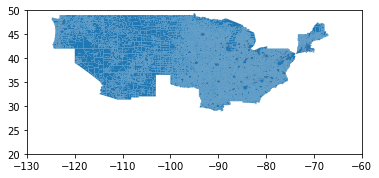

In [14]:
fig,ax = plt.subplots(1,1)
newtestgdf.plot(ax=ax)
plt.xlim(-130,-60)
plt.ylim(20,50)
plt.show()



## PENNSYLVANIA

### Get water areas for whole state

In [15]:
# s = time.time()

# this_state = 'PA'
# this_state_number = 42
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading area water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of linear water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# old_map_buffer_ratio = -1

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))



### Define Philadelphia area

In [16]:
# s = time.time()
# nDistricts = 18
# print('making box...')
# urban_east_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state)].geometry.tolist()).bounds[2]
# urban_south_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state)].geometry.tolist()).bounds[1]

# urban_west_limit = -76.5
# urban_north_limit = 41.18

# xlim = [urban_west_limit, urban_east_limit]
# ylim = [urban_south_limit, urban_north_limit]

# urban_geo = makebox(xlim, ylim)

# e = time.time()
# g = g + (e-s)
# print('Defined Urban (Philadelphia) area in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



In [17]:
# s = time.time()
# print('plotting...')
# urban_geo_gdf = geopandas.GeoDataFrame(data=[[urban_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')

# fig, ax = plt.subplots(1,1)

# assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax)

# for i in range(1, nDistricts+1):
#     cd_gdf[
#         (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
#     ].plot(ax=ax, color=district_color_cycle[i-1], alpha=0.5)
#     annotator = i
#     centerpoint = cd_gdf[
#         (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
#     ].geometry.apply(lambda x: (x.centroid.x, x.centroid.y)).values[0]
#     plt.annotate(annotator, centerpoint, 
#                  ha='center', va='center', fontsize=8,
#                  color='black', backgroundcolor='white')

# urban_geo_gdf.plot(ax=ax, color='none', edgecolor='black')

# # plt.xlim(urban_west_limit, urban_east_limit)
# # plt.ylim(urban_south_limit, urban_north_limit)
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Plotted urban (Philadelphia) area in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


### Split water areas, places, roads into urban/rural

In [18]:
# s = time.time()
# print('splitting water areas...')
# water_urban_gdf = water_gdf[water_gdf.geometry.within(urban_geo)]
# water_rural_gdf = water_gdf[~water_gdf.geometry.within(urban_geo)]

# print('splitting places...')
# place_urban_gdf = place_gdf[place_gdf.geometry.within(urban_geo)]
# place_rural_gdf = place_gdf[~place_gdf.geometry.within(urban_geo)]

# print('splitting roads...')
# roads_urban_gdf = roads_gdf[roads_gdf.geometry.within(urban_geo)]
# roads_rural_gdf = roads_gdf[~roads_gdf.geometry.within(urban_geo)]
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} seconds!'.format(e-s))

### Find urban districts (Philadelphia)

In [19]:
# print('getting frpm backup...')
# assembler_gdf = assembler_gdf_bk




# assembler_gdf = assembler_gdf.assign(bitmask_philly = assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf.geometry.apply(lambda x: x.within(urban_geo)))
#      & (assembler_gdf['block_based_district'] == -1)
# ]['congressional_districts_bitmask'].apply(lambda x: x[:12])
#                                     )

# print('Assigned Philly bitmask values to {0:,.0f} block groups'.format(len(assembler_gdf['bitmask_philly'].dropna())))

# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state)
# #     & (assembler_gdf.geometry.apply(lambda x: x.bounds[1]) < north_boundary_of_nyc)
# # ]

# assembler_gdf.groupby('bitmask_philly').size().sort_index(ascending=False)



### Examine tracts that match multiple districts (urban Philly)

In [20]:
# s = time.time()

# this_state = 'PA'
# test_this_bitmask_philly = 'x00000001100'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True


# legend_location = 'lower left'

# map_buffer_ratio = .1

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask_philly)):
#         if (test_this_bitmask_philly[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & 
#         (assembler_gdf['bitmask_philly'] == test_this_bitmask_philly)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=2, zorder=100)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['bitmask_philly'] == test_this_bitmask_philly)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['bitmask_philly'] == test_this_bitmask_philly) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_urban_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_urban_gdf[~roads_urban_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_urban_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=3)
# #     print('\tlabeling places in map area...')
# #     for ix, thisrow in place_urban_gdf[
# #         ((place_urban_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_urban_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
# #         & ((place_urban_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_urban_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
# #     ].sort_values(by='NAME').iterrows():
# #         print('\t{0:}...'.format(thisrow['NAME']))
# #         annotator = thisrow['NAME'].upper()
# #         ax2.annotate(annotator, 
# #                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      color='black', backgroundcolor='white', fontsize=9, ha='center'
# #                    )
#     print('\tlabeling places in chosen tracts...')
#     for ix, thisrow in place_urban_gdf[
#         ((place_urban_gdf['INTPTLON'] >= xlimits[0]) & (place_urban_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_urban_gdf['INTPTLAT'] >= ylimits[0]) & (place_urban_gdf['INTPTLAT'] <= ylimits[1]))        
# #        & (place_urban_gdf['NAME'].apply(lambda x: ('montgomery' in x.lower()) | ('soud' in x.lower())))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=12, ha='center', va='center')

        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


#### Examine a single district in more detail

In [21]:
# s = time.time()

# label_small_roads = True
# label_small_road_types = []
# show_places = False
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# oldi = -1

# i = 1

# map_buffer_ratio = .25

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US170978660001'

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_bitmask_philly)):
#     if (test_this_bitmask_philly[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[j-1], label='District {0:,.0f}'.format(j)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[j-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_urban_gdf[water_urban_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_urban_gdf[roads_urban_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_urban_gdf[roads_urban_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color='red', linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color='black', linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color='orange', linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center'
#                         , zorder=200)


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_urban_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='red', lw=3)
#     print('\tlabeling places...')
#     for ix, thisrow in place_urban_gdf[
#         ((place_urban_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_urban_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_urban_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_urban_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=11, ha='center', va='center')

# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=11, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     print(other_roads)
# pprint(this_block_group_id)




In [22]:
### Do block-based district boundaries approximately follow real boundaries? (Urban Philly)

In [23]:
# s = time.time()
# this_state = 'PA'
# nDistricts = 18

# thedistricts = [3,5]


# manual_xlim = (-75.25,-75.12)
# manual_ylim = (39.86,39.95)

# legend_location = 'upper right'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[i-1], edgecolor='black', lw=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
    
#     #ax.legend(handles=legend_list, fontsize=14, loc=legend_location)

#     cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor='purple', lw=3)
    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# # print('labeling block groups...')
# # #####  add labels for block groups with overlap
# # b = []
# # for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     #& (assembler_gdf['block_based_district'] == 7) 
# #     #& (assembler_gdf.index == '15000US170318392001')
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# # ].iterrows():
# #     b.append(ix)
# #     annotator = ix[-6:]
# #     ax1.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
# #                )

# print('plotting water...')    
# water_urban_gdf[
#     (water_urban_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_urban_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#     & (water_urban_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_urban_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# ].plot(ax=ax2, color='blue')

# # b = sorted(b)
# # for i in range(0,len(b)):
# #     print(b[i])

# plt.show()


In [24]:
## Assign districts (rural Pennsylvania)

In [25]:
print('getting from backup...')
assembler_gdf = assembler_gdf_bk

assembler_gdf.loc[['15000US420970823001'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US421330229103', '15000US421330229104', '15000US421330228004'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US421330228006'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US420410119023'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US420410119011', '15000US420410119012'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US420010308004'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US420270112012'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US420270119011'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US420279812021'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US421298072004'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US421298072003'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US420210101002'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US420210101001'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US420199115012'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US420199115014'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US420199120011', '15000US420199120012', '15000US420199123012'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US420199120022', '15000US420199123041'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US420035235021'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US420034560011', '15000US420034560012', '15000US420034560031'], 'block_based_district'] = 18


bitmask_shiftor = 8

if ('bitmask_shifted' not in assembler_gdf.columns):
    assembler_gdf = assembler_gdf.assign(bitmask_shifted = np.nan)
    

assembler_gdf.loc[
    (assembler_gdf['STUSAB'] == this_state)
    & (assembler_gdf.geometry.apply(lambda x: not(x.within(urban_geo))))
    & (assembler_gdf['block_based_district'] == -1), 'bitmask_shifted'
] = assembler_gdf[(assembler_gdf['STUSAB'] == this_state)
    & (assembler_gdf.geometry.apply(lambda x: not(x.within(urban_geo))))
    & (assembler_gdf['block_based_district'] == -1)
                 ]['congressional_districts_bitmask'].apply(lambda x: 'x'+x[bitmask_shiftor+1:])

assembler_gdf[
    (assembler_gdf['STUSAB'] == this_state)
    & (assembler_gdf['block_based_district'] == -1)
].groupby('bitmask_shifted').size().sort_index(ascending=False)


getting from backup...


NameError: name 'urban_geo' is not defined

#### Examine districts (rural)

In [ ]:
s = time.time()


this_state = 'PA'
test_this_bitmask_shifted = 'x0000000011'

manual_plot_limits = False
show_small_roads = True
show_places = False
show_water = True


manual_xlim = (-89.95,-89.5)
manual_ylim = (40.43,40.77)


legend_location = 'upper left'

map_buffer_ratio = .1

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
#fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

print('Plotting official districts...')
for ax in (ax1, ax2):
    legend_list = []
    for i in range(1, len(test_this_bitmask_shifted)):
        if (test_this_bitmask_shifted[i] == '1'):
            cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i+bitmask_shiftor)].plot(ax=ax, color=district_color_cycle[i+bitmask_shiftor-1], label='District {0:.0f}'.format(i+bitmask_shiftor))
            legend_list.append(mpatches.Patch(color=district_color_cycle[i+bitmask_shiftor-1], label='District {0:,.0f}'.format(i+bitmask_shiftor)))


print('plotting tracts that overlap multiple districts...')
for ax in (ax1,ax2):
    assembler_gdf[
        (assembler_gdf['block_based_district'] == -1)
        & 
        (assembler_gdf['bitmask_shifted'] == test_this_bitmask_shifted)
    ].plot(ax=ax, color='none', edgecolor='white', linewidth=2, zorder=100)

    if (manual_plot_limits):
        xlimits = (manual_xlim[0], manual_xlim[1])
        ylimits = (manual_ylim[0], manual_ylim[1])
    else:
        bounding_box = unary_union(
            assembler_gdf[
                (assembler_gdf['block_based_district'] == -1)
                & (assembler_gdf['bitmask_shifted'] == test_this_bitmask_shifted)
            ].geometry.tolist()
        ).bounds
        xlimits = (bounding_box[0], bounding_box[2])
        ylimits = (bounding_box[1], bounding_box[3])

    xspan = xlimits[1] - xlimits[0]
    yspan = ylimits[1] - ylimits[0]
    xbuffer = xspan * map_buffer_ratio
    ybuffer = yspan * map_buffer_ratio
    ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
    ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
    ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


print('labeling block groups...')
#####  add labels for block groups with overlap
b = []
for ix, thisrow in assembler_gdf[
    (assembler_gdf['STUSAB'] == this_state) 
    & (assembler_gdf['block_based_district'] == -1) 
    & (assembler_gdf['bitmask_shifted'] == test_this_bitmask_shifted) 
    & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
    & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
].iterrows():
    b.append(ix)
    annotator = ix[-6:]
    ax1.annotate(annotator, 
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                 color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
               )
b = sorted(b)
for i in range(0,len(b)):
    print(b[i])

if (show_water):
    print('plotting water...')
    water_rural_gdf.plot(ax=ax2, color='blue')

print('plotting roads...')
if (show_small_roads):
    roads_rural_gdf[~roads_rural_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color=road_label_format['M']['thecolor'], linewidth=0.25) 
roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'C'].plot(ax=ax2, color=road_label_format['C']['thecolor'], linewidth=0.5) 
roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'S'].plot(ax=ax2, color=road_label_format['S']['thecolor'], linewidth=1) 
roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'U'].plot(ax=ax2, color=road_label_format['U']['thecolor'], linewidth=1.5) 
roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'I'].plot(ax=ax2, color=road_label_format['I']['thecolor'], linewidth=2) 

if (show_places):
    print('plotting places...')
    place_rural_gdf[
                ( (place_rural_gdf['NAME'].apply(lambda x: 'peoria' in x.lower())) | (place_rural_gdf['NAME'].apply(lambda x: 'pekin' in x.lower())) )
    ].plot(ax=ax, color='none', edgecolor='yellow', linewidth=13)
    print('\tlabeling places in map area...')
    for ix, thisrow in place_rural_gdf[
        ((place_rural_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_rural_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
        & ((place_rural_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_rural_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
    ].sort_values(by='NAME').iterrows():
        print('\t{0:}...'.format(thisrow['NAME']))
        annotator = thisrow['NAME'].upper()
        ax2.annotate(annotator, 
                         (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                         (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
                     color='black', backgroundcolor='white', fontsize=8, ha='center'
                   )
#     print('\tlabeling places in chosen tracts...')
#     for ix, thisrow in place_rural_gdf[
#         ((place_rural_gdf['INTPTLON'] >= xlimits[0]) & (place_rural_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_rural_gdf['INTPTLAT'] >= ylimits[0]) & (place_rural_gdf['INTPTLAT'] <= ylimits[1]))        
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=11, ha='center', va='center')

        
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

explore_more = b
oldi = -1
old_map_bufer_ratio = -1
plt.show()
e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


In [ ]:
#### Examine a single district in more detail (rural)

In [ ]:
s = time.time()

label_small_roads = True
label_small_road_types = ['Ave','Pl']
show_places = False
show_water = True
basesize = 12
aspect_ratio = xspan / yspan
oldi = -1

i = 0

map_buffer_ratio = .5

suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
other_roads = []


if (oldi != i):
    print('Running this cell for the first time...')
this_block_group_id = explore_more[i]

this_block_group_id = '15000US420035235021'

print('Examining block group {0:}'.format(this_block_group_id))
print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

xspan = xlimits[1] - xlimits[0]
yspan = ylimits[1] - ylimits[0]
aspect_ratio = xspan / yspan

xbuffer = xspan * map_buffer_ratio
ybuffer = yspan * map_buffer_ratio

xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
    map_area_geo = makebox(xlimits, ylimits)

map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
print('\n')

fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

legend_list = []
for j in range(1, len(test_this_bitmask_shifted)):
    if (test_this_bitmask_shifted[j] == '1'):
        print('Matching District {0:}...'.format(j))
        legend_list.append(mpatches.Patch(color=district_color_cycle[j+bitmask_shiftor-1], label='District {0:,.0f}'.format(j+bitmask_shiftor)))
        cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j + bitmask_shiftor)].plot(ax=ax, color=district_color_cycle[j+bitmask_shiftor-1])
        overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j+bitmask_shiftor)].to_crs(equal_area_crs), how='intersection').area.values[0]
        print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
print('\n')



block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

print('finding water overlap...')
if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
    water_in_map_area_gdf = water_urban_gdf[water_urban_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
    #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
water_in_map_area_gdf.plot(ax=ax, color='blue')

print('finding road overlap...')
if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
    print('\twith block group...')
    roads_in_block_group_gdf = roads_rural_gdf[roads_rural_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
    print('\twith full map area...')
    roads_in_map_area_gdf = roads_rural_gdf[roads_rural_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color='red', linewidth=0.5) 
roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color='black', linewidth=1) 
roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=2)
roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=3)
roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=4)
roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color='orange', linewidth=5)


print('labeling big roads in map area...')
for ix, thisrow in roads_in_map_area_gdf[
    (roads_in_map_area_gdf['FULLNAME'].notnull()) 
    & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
    annotator = parse_road_name(thisrow['FULLNAME'])
    centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
    if (map_area_geo.contains(centerpoint)):
        plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                     color='black', backgroundcolor='white', ha='center', va='center',
                     fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
if (label_small_roads):    
    print('labeling small roads in block group...')
    for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
        #print('\t{0:}'.format(thisrow['FULLNAME']))
        is_other_road_type = False
        try:
            road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
            if (road_suffix in suffixes_to_count_dict):
                suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
        except AttributeError:
            is_other_road_type = True 
            other_roads.append(thisrow['FULLNAME'])
        
        if ((road_suffix in label_small_road_types) | (is_other_road_type)):
            annotator = thisrow['FULLNAME']            
            plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                 color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center'
                        , zorder=200)


plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

if (label_small_roads):
    print("\tAnalysis of road names:")
    for k,v in suffixes_to_count_dict.items():
        print('\t\t{0:}: {1:,.0f}'.format(k,v))
    print('\tOther road names:')
    for x in other_roads:
        print('\t\t',x)
    print('\n')

if (show_places):
    print('finding places...')
    print('\tshowing place names...')
    for ix, thisrow in place_rural_gdf.iterrows():
        if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
            print('\t\t',str(thisrow['NAME']))
    print('\tplotting places...')    
    place_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=3)
    print('\tlabeling places...')
    for ix, thisrow in place_rural_gdf[
        ((place_rural_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_rural_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
        & ((place_rural_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_rural_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
    ].iterrows():
        annotator = thisrow['NAME'].upper()
        plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                 color='red', backgroundcolor='white', fontsize=11, ha='center', va='center')

print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

ax.legend(handles=legend_list, fontsize=11, loc=legend_location)
plt.xlim(xlimits)
plt.ylim(ylimits)

# plt.xticks(fontsize=24)
# plt.yticks(fontsize=24)


plt.show()




oldi = i
old_map_buffer_ratio = map_buffer_ratio

e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

#map_area_geo
if (label_small_roads):
    print(other_roads)
pprint(this_block_group_id)




## ILLINOIS

## Get water areas etc for whole state

In [ ]:
# s = time.time()

# this_state = 'IL'
# this_state_number = 17
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading area water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of linear water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# old_map_buffer_ratio = -1

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))



## Define Chicago area
# East of 88.69 West
# North of 41.25 North

In [ ]:
# s = time.time()
# print('making box...')
# urban_east_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state)].geometry.tolist()).bounds[2]
# urban_north_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == this_state)].geometry.tolist()).bounds[3]

# urban_west_limit = -88.69
# urban_south_limit = 41.25

# xlim = [urban_west_limit, urban_east_limit]
# ylim = [urban_south_limit, urban_north_limit]

# urban_geo = makebox(xlim, ylim)

# print('plotting...')
# urban_geo_gdf = geopandas.GeoDataFrame(data=[[urban_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')

# fig, ax = plt.subplots(1,1)
# assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax)
# urban_geo_gdf.plot(ax=ax, color='none', edgecolor='black')

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} seconds!'.format(e-s))
# plt.show()

## Split water areas, places, roads into urban/rural

In [ ]:
# s = time.time()
# print('splitting water areas...')
# water_urban_gdf = water_gdf[water_gdf.geometry.within(urban_geo)]
# water_rural_gdf = water_gdf[~water_gdf.geometry.within(urban_geo)]

# print('splitting places...')
# place_urban_gdf = place_gdf[place_gdf.geometry.within(urban_geo)]
# place_rural_gdf = place_gdf[~place_gdf.geometry.within(urban_geo)]


# print('splitting roads...')
# roads_urban_gdf = roads_gdf[roads_gdf.geometry.within(urban_geo)]
# roads_rural_gdf = roads_gdf[~roads_gdf.geometry.within(urban_geo)]
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} seconds!'.format(e-s))

### Fix rural districts and shift bitmasks

In [ ]:

# if ('bitmask_shifted' not in assembler_gdf.columns):
#     assembler_gdf = assembler_gdf.assign(bitmask_shifted = np.nan)
    

# assembler_gdf.loc[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf.geometry.apply(lambda x: not(x.within(urban_geo))))
#     & (assembler_gdf['block_based_district'] == -1), 'bitmask_shifted'
# ] = assembler_gdf[(assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf.geometry.apply(lambda x: not(x.within(urban_geo))))
#     & (assembler_gdf['block_based_district'] == -1)
#                  ]['congressional_districts_bitmask'].apply(lambda x: 'x'+x[12:])

# bitmask_shiftor = 11
# assembler_gdf[
#     (assembler_gdf['block_based_district'] == -1)
# ].groupby('bitmask_shifted').size().sort_index(ascending=False)



#### Examine districts (rural)

In [ ]:
# s = time.time()


# this_state = 'IL'
# test_this_bitmask_shifted = 'x0000011'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# # 17 vs 18 all
# manual_xlim = (-89.95,-89.5)
# manual_ylim = (40.43,40.77)


# legend_location = 'lower left'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask_shifted)):
#         if (test_this_bitmask_shifted[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i+bitmask_shiftor)].plot(ax=ax, color=district_color_cycle[i+bitmask_shiftor-1], label='District {0:.0f}'.format(i+bitmask_shiftor))
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i+bitmask_shiftor-1], label='District {0:,.0f}'.format(i+bitmask_shiftor)))


# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & 
#         (assembler_gdf['bitmask_shifted'] == test_this_bitmask_shifted)
#     ].plot(ax=ax, color='none', edgecolor='white', linewidth=2, zorder=100)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['bitmask_shifted'] == test_this_bitmask_shifted)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['bitmask_shifted'] == test_this_bitmask_shifted) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_rural_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_rural_gdf[~roads_rural_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color=road_label_format['M']['thecolor'], linewidth=0.25) 
# roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'C'].plot(ax=ax2, color=road_label_format['C']['thecolor'], linewidth=0.5) 
# roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'S'].plot(ax=ax2, color=road_label_format['S']['thecolor'], linewidth=1) 
# roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'U'].plot(ax=ax2, color=road_label_format['U']['thecolor'], linewidth=1.5) 
# roads_rural_gdf[roads_rural_gdf['RTTYP'] == 'I'].plot(ax=ax2, color=road_label_format['I']['thecolor'], linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_rural_gdf[
#                 ( (place_rural_gdf['NAME'].apply(lambda x: 'peoria' in x.lower())) | (place_rural_gdf['NAME'].apply(lambda x: 'pekin' in x.lower())) )
#     ].plot(ax=ax, color='none', edgecolor='magenta', linewidth=3)
#     print('\tlabeling places in map area...')
#     for ix, thisrow in place_rural_gdf[
#         ((place_rural_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_rural_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_rural_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_rural_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#         & ( (place_rural_gdf['NAME'].apply(lambda x: 'peoria' in x.lower())) | (place_rural_gdf['NAME'].apply(lambda x: 'pekin' in x.lower())) )
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='black', backgroundcolor='white', fontsize=8, ha='center'
#                    )
# #     print('\tlabeling places in chosen tracts...')
# #     for ix, thisrow in place_rural_gdf[
# #         ((place_rural_gdf['INTPTLON'] >= xlimits[0]) & (place_rural_gdf['INTPTLON'] <= xlimits[1]))
# #         & ((place_rural_gdf['INTPTLAT'] >= ylimits[0]) & (place_rural_gdf['INTPTLAT'] <= ylimits[1]))        
# #     ].iterrows():
# #         annotator = thisrow['NAME'].upper()
# #         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                  color='black', backgroundcolor='white', fontsize=11, ha='center', va='center')

        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


#### Examine further

In [ ]:

# s = time.time()


# label_small_roads = True
# label_small_road_types = ['Ave']
# show_places = False
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# oldi = -1

# i = 9  # to 9

# map_buffer_ratio = .05

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US170978660001'

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_bitmask_shifted)):
#     if (test_this_bitmask_shifted[j] == '1'):
#         print('Matching District {0:}...'.format(j+bitmask_shiftor))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[j-1], label='District {0:,.0f}'.format(j+bitmask_shiftor)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j+bitmask_shiftor)].plot(ax=ax, color=district_color_cycle[j+bitmask_shiftor-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j+bitmask_shiftor)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_rural_gdf[water_rural_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_rural_gdf[roads_rural_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_rural_gdf[roads_rural_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color=road_label_format['M']['thecolor'], linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color=road_label_format['M']['thecolor'], linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color=road_label_format['C']['thecolor'], linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color=road_label_format['S']['thecolor'], linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color=road_label_format['U']['thecolor'], linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color=road_label_format['I']['thecolor'], linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center'
#                         , zorder=200)


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_rural_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_rural_gdf.plot(ax=ax, color='none', edgecolor='magenta', lw=4)
#     print('\tlabeling places...')
#     for ix, thisrow in place_rural_gdf[
#         ((place_rural_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_rural_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_rural_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_rural_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=12, ha='center', va='center')

# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=11, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     print(other_roads)
# pprint(this_block_group_id)



### Do block-based district boundaries approximately follow real boundaries? (Rural)

In [ ]:
# s = time.time()
# this_state = 'IL'
# nDistricts = 18

# thedistricts = [17,18]



# manual_xlim = (-89.72,-89.54)
# manual_ylim = (40.64,40.75)

# # manual_xlim = (-89.59,-89.55)
# # manual_ylim = (40.69,40.73)


# legend_location = 'upper right'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[i-1], edgecolor='black', lw=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

# #    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor='magenta', lw=3)
    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# print('labeling block groups...')
# ####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf['block_based_district'] == 7) 
#     #& (assembler_gdf.index == '15000US170318392001')
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )

# print('plotting water...')    
# water_rural_gdf[
#     (water_rural_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_urban_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#     & (water_rural_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_urban_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# ].plot(ax=ax2, color='gray')

# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# plt.show()


### Assigning districts in the Chicago area (urban)

In [ ]:

# print('getting frpm backup...')
# assembler_gdf = assembler_gdf_bk


# assembler_gdf = assembler_gdf.assign(bitmask_chicago = assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf.geometry.apply(lambda x: x.within(urban_geo)))
#      & (assembler_gdf['block_based_district'] == -1)
# ]['congressional_districts_bitmask'].apply(lambda x: x[:17])
#                                     )

# print('Assigned Chicago bitmask values to {0:,.0f} block groups'.format(len(assembler_gdf['bitmask_chicago'].dropna())))

# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state)
# #     & (assembler_gdf.geometry.apply(lambda x: x.bounds[1]) < north_boundary_of_nyc)
# # ]

# assembler_gdf.groupby('bitmask_chicago').size().sort_index(ascending=False)



#### Examine districts

In [ ]:
# s = time.time()

# this_state = 'IL'
# test_this_bitmask_chicago = 'x0000000000000101'

# manual_plot_limits = False
# show_small_roads = True
# show_places = True
# show_water = True




# legend_location = 'upper right'

# map_buffer_ratio = .05

# #fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask_chicago)):
#         if (test_this_bitmask_chicago[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & 
#         (assembler_gdf['bitmask_chicago'] == test_this_bitmask_chicago)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=2, zorder=100)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['bitmask_chicago'] == test_this_bitmask_chicago)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['bitmask_chicago'] == test_this_bitmask_chicago) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_urban_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_urban_gdf[~roads_urban_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_urban_gdf[roads_urban_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_urban_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=3)
#     print('\tlabeling places in map area...')
#     for ix, thisrow in place_urban_gdf[
#         ((place_urban_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_urban_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_urban_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_urban_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='red', backgroundcolor='white', fontsize=9, ha='center'
#                    )
#     print('\tlabeling places in chosen tracts...')
#     for ix, thisrow in place_urban_gdf[
#         ((place_urban_gdf['INTPTLON'] >= xlimits[0]) & (place_urban_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_urban_gdf['INTPTLAT'] >= ylimits[0]) & (place_urban_gdf['INTPTLAT'] <= ylimits[1]))        
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')

        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


### Examine single tracts in detail (urban)

In [ ]:
# s = time.time()

# label_small_roads = False
# label_small_road_types = ['Rd','Dr','Ave']
# show_places = False
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# oldi = -1

# i = 2

# map_buffer_ratio = .75

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US170978660001'

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_bitmask_chicago)):
#     if (test_this_bitmask_chicago[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[j-1], label='District {0:,.0f}'.format(j)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[j-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_urban_gdf[water_urban_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_urban_gdf[roads_urban_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_urban_gdf[roads_urban_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color='red', linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color='black', linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color='orange', linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center'
#                         , zorder=200)


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_urban_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='cyan', lw=3)
#     print('\tlabeling places...')
#     for ix, thisrow in place_urban_gdf[
#         ((place_urban_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_urban_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_urban_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_urban_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=11, ha='center', va='center')

# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=11, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     print(other_roads)
# pprint(this_block_group_id)



### Do block-based district boundaries approximately follow real boundariess? (Urban)

In [ ]:
# s = time.time()
# this_state = 'IL'
# nDistricts = 18

# thedistricts = [11,14]


# ### 11 VS 14 EVERYTHING
# manual_xlim = (-88.55,-88.1)
# manual_ylim = (41.45,41.75)

# legend_location = 'center left'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[i-1], edgecolor='black', lw=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

#     cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor='purple', lw=3)
    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# # print('labeling block groups...')
# # #####  add labels for block groups with overlap
# # b = []
# # for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     #& (assembler_gdf['block_based_district'] == 7) 
# #     #& (assembler_gdf.index == '15000US170318392001')
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# # ].iterrows():
# #     b.append(ix)
# #     annotator = ix[-6:]
# #     ax1.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
# #                )

# print('plotting water...')    
# water_urban_gdf[
#     (water_urban_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_urban_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#     & (water_urban_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_urban_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# ].plot(ax=ax2, color='blue')

# # b = sorted(b)
# # for i in range(0,len(b)):
# #     print(b[i])

# plt.show()



## OHIO

In [ ]:


# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'OH')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# # congressional_districts_bitmask
# # x1100000000000000    50
# # x0100010000000000    15
# # x0100000000000010    13
# # x0010000000010000    38
# # x0010000000000010    76
# # x0001100000000000     3
# # x0001001000000000    15
# # x0001000100000000     2
# # x0001000010000000    15
# # x0001000000010000     3
# # x0000100100000000     3
# # x0000100010000000    19
# # x0000011000000000     7
# # x0000010000010000    15
# # x0000010000001000     2
# # x0000010000000010     3
# # x0000001000010000    19
# # x0000001000001000     4
# # x0000001000000001    44
# # x0000000010100000    20
# # x0000000010000001    17
# # x0000000001000010     6
# # x0000000000101001     3
# # x0000000000101000    58
# # x0000000000100001     6
# # x0000000000010010    15
# # x0000000000001100    20
# # x0000000000001001    13


In [ ]:
# s = time.time()

# this_state = 'OH'
# test_this_bitmask = 'x0000000000001001'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# manual_xlim = (-81.54,-81.45)
# manual_ylim = (41.083,41.125)



# legend_location = 'upper left'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & 
#         (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='white', linewidth=2, zorder=100)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=3)
#     print('\tlabeling places in map area...')
#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='red', backgroundcolor='white', fontsize=9, ha='center'
#                    )
#     print('\tlabeling places in chosen tracts...')
#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0]) & (place_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0]) & (place_gdf['INTPTLAT'] <= ylimits[1]))        
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')

        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



In [ ]:
# s = time.time()

# label_small_roads = False
# label_small_road_types = ['Ave','Dr','St'] #['Pkwy', 'St', 'Way', 'Dr', 'Blvd', 'Rd']
# show_places = True
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# oldi = -1

# i = 0

# map_buffer_ratio = .25

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US391535201051'

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[j-1], label='District {0:,.0f}'.format(j)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[j-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=6, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_gdf[water_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color='red', linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color='black', linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color='orange', linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='cyan', lw=3)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     pprint(suffixes_to_count_dict)
#     print(other_roads)
# pprint(this_block_group_id)



In [ ]:
# s = time.time()

# this_state = 'OH'
# this_state_number = 39

# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading area water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of linear water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))



In [ ]:
# s = time.time()

# this_state = 'OH'
# test_this_bitmask = 'x0000000000001100'
# thedistricts = [13,14]

# manual_xlim = (-81.53,-81.44)
# manual_ylim = (41.03,41.1)


# legend_location = 'upper right'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[i-1], edgecolor='black', lw=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

#     cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor='purple', lw=3)
    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# plt.show()